## **SME0828 - Introdução à Ciência de Dados**
### **Projeto Final**

- Carolina Spera Braga 

## **1. Introdução**

- **Detecção de fraude em pagamentos online**

Nosso objetivo é identificar fraude em pagamentos online, para isso iremos treinar modelos para classificação de pagamentos em fraudulentos e não fraudulentos. Iremos testar vários classificadores distintos e concluir com base no mais eficiente dentre eles.

Iremos utilizar o seguinte *dataset* do *Kaggle*:
https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset, contendo informação sobre fraude em pagamentos online, de forma que verificamos quais tipos de transações levam à fraude.

Os dados contém informação histórica sobre transações fraudulentas que podem ser utilizadas para gerar os classificadores.

Seguem as definições de cada atributo do *dataset*:


    step: representa a unidade de tempo, onde 1 step é igual a 1 hora 
    type: tipo de pagamento feito online 
    amount: a quantidade usada no pagamento
    nameOrig: cliente inicia o pagamento 
    oldbalanceOrg: receita do cliente antes do pagamento 
    newbalanceOrig: receita do cliente após o pagamento
    nameDest: destino do pagamento
    oldbalanceDest: receita inicial do destino do pagamento 
    newbalanceDest: receita final do destino após o pagamento 
    isFraud: pagamento fraudulento



## **2. Preparação e transformação dos dados**

In [ ]:
# Bibliotecas utilizadas
import random

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.datasets as skdata
from pandas import DataFrame
from matplotlib import pyplot

from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from mlxtend.plotting import plot_decision_regions
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_curve, auc

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

In [ ]:
data = pd.read_csv("PS_20174392719_1491204439457_log.csv")

In [ ]:
print("Número de linhas e colunas do dataframe: ", data.shape)
data.head(5)

Número de linhas e colunas do dataframe:  (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Vamos verificar se existem valores nulos no conjunto de dados

In [ ]:
print(data.isna().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


Vemos que este conjunto de dados não possui valores nulos. Vamos verificar agora os tipos de cada transação:


In [ ]:
# Tipos das transações
print(data.type.value_counts())

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


Vamos remover possíveis linhas duplicadas e valores da forma "?" dos dados:


In [ ]:
# Note que não há entradas duplicadas no conjunto
len(data[data.duplicated()])

0

In [ ]:
# Nem "?"
len(data[data.eq("?").any(1)])

0

Desta forma, temos um conjunto de dados sem erros e entradas duplicadas.

- Vamos transformar as variáveis categóricas em numéricas. Aqui também transformaremos os valores da coluna 'isFraud' para 'Não Fraude' e 'Fraude' para ter um melhor entendimento da saída. A transformação é feita para o data frame com os Merchants e para o data frame sem os Merchants.


In [ ]:
# Transformação para os dados com os Merchants
data["type"] = data["type"].map({"CASH_OUT": 1, "PAYMENT": 2, 
                                 "CASH_IN": 3, "TRANSFER": 4,
                                 "DEBIT": 5})
#data["isFraud"] = data["isFraud"].map({0: "Não Fraude", 1: "Fraude"})
print(data.head())

   step  type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1     2   9839.64  C1231006815       170136.0       160296.36   
1     1     2   1864.28  C1666544295        21249.0        19384.72   
2     1     4    181.00  C1305486145          181.0            0.00   
3     1     1    181.00   C840083671          181.0            0.00   
4     1     2  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


## **3. Análise Exploratória dos Dados**

Selecionamos apenas os casos de fraude e verificamos se existem pagadores cometendo mais de uma fraude e recebedores recebendo mais de uma fraude.

In [ ]:
data_fraude = data.loc[data['isFraud'] == 1]

# Recebedores que recebem mais de uma fraude
ids_d = data_fraude["nameDest"]
recebedores_fraudes = data_fraude[ids_d.isin(ids_d[ids_d.duplicated()])].sort_values("nameDest")

# Pagadores que cometem mais de uma fraude
ids_o = data_fraude["nameOrig"]
pagadores_fraudes = data_fraude[ids_o.isin(ids_o[ids_o.duplicated()])].sort_values("nameOrig")

In [ ]:
recebedores_fraudes

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
49826,9,1,2539898.07,C728718059,2539898.07,0.0,C1013511446,968.00,1842864.22,1,0
1030590,74,1,455074.13,C695129655,455074.13,0.0,C1013511446,9237170.74,9692244.86,1,0
1030368,59,1,2050727.81,C992917413,2050727.81,0.0,C104038589,0.00,2050727.81,1,0
788647,39,4,152042.16,C1118399210,152042.16,0.0,C104038589,0.00,0.00,1,0
3960313,294,1,290090.57,C2076884011,290090.57,0.0,C105660024,2000395.18,2290485.75,1,0
...,...,...,...,...,...,...,...,...,...,...,...
637350,35,4,472692.51,C892010542,472692.51,0.0,C935310781,0.00,0.00,1,0
4058811,300,1,176059.16,C1203474575,176059.16,0.0,C964377943,105783.21,281842.36,1,0
5801852,401,1,5838803.23,C388640141,5838803.23,0.0,C964377943,471758.21,6310561.44,1,0
1832574,163,1,762135.72,C1088995906,762135.72,0.0,C967226405,47768.78,809904.50,1,0


In [ ]:
pagadores_fraudes

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud


## **3.1 Análise dos Merchants** 

Todos os destinos de pagamentos que começam com a letra "M" são chamados de Merchants, e sobre eles não temos informação sobre receita antes e depois do pagamento, logo, precisamos fazer uma análise da importância dos dados que os contenham para verificarmos se faz sentido manter esses dados ou não para treinar os modelos dos classificadores.


- Iniciamos com a verificação de quantas linhas do *dataset* são representas por Merchants, pois precisamos verificar se a quantidade é significativa.

In [ ]:
pd_series = pd.Series(data['nameDest'])
data.loc[(pd_series.str.startswith('M',na=False))]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,2,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,2,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
4,1,2,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0
5,1,2,7817.71,C90045638,53860.0,46042.29,M573487274,0.0,0.0,0,0
6,1,2,7107.77,C154988899,183195.0,176087.23,M408069119,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362312,718,2,8178.01,C1213413071,11742.0,3563.99,M1112540487,0.0,0.0,0,0
6362314,718,2,17841.23,C1045048098,10182.0,0.00,M1878955882,0.0,0.0,0,0
6362316,718,2,1022.91,C1203084509,12.0,0.00,M675916850,0.0,0.0,0,0
6362318,718,2,4109.57,C673558958,5521.0,1411.43,M1126011651,0.0,0.0,0,0


Vemos que do total de 6362620 linhas, 2151495 são Merchants, ou seja, 2151495/6362620 = 0.338 = 33.8% dos dados, o que é uma quantidade significativa.

- Vamos verificar se existem casos de fraude para os recebedores classificados como Merchants:

In [ ]:
pd_series = pd.Series(data['nameDest'])
M_df = data.loc[(pd_series.str.startswith('M',na=False)) & (data['isFraud']==1)]
M_df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud


Podemos observar que não existem fraudes para os Merchants, e como não possuímos informações sobre eles sobre saldo anterior e posterior podemos concluir que eles podem não ser significantes para modelarmos os classificadores.

Dito isso, iremos eliminar as linhas contendo os Merchants dos dados e realizar a classificação com eles e em seguida sem eles para verificar qual modelo será mais adequado.

O data frame sem os Merchants é da forma:

In [ ]:
pd_series = pd.Series(data['nameDest'])
no_M_df = data.loc[~(pd_series.str.startswith('M',na=False))]
no_M_df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,4,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,1,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
9,1,5,5337.77,C712410124,41720.00,36382.23,C195600860,41898.00,40348.79,0,0
10,1,5,9644.94,C1900366749,4465.00,0.00,C997608398,10845.00,157982.12,0,0
15,1,1,229133.94,C905080434,15325.00,0.00,C476402209,5083.00,51513.44,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,1,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,4,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,1,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,4,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


- Vamos verficar a quantidade de fraudes e não fraudes para os dados com os merchants

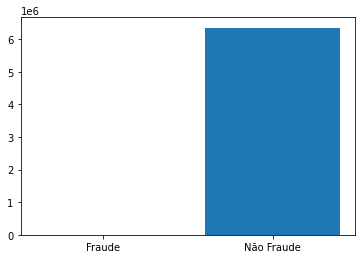

Fraudes: 8213
Não Fraudes: 6354407


In [ ]:
# Fraude vs Não Fraude com os Merchants
h = [sum(data['isFraud']==1), sum(data['isFraud']==0)]
b = ('Fraude', 'Não Fraude')
y_pos = np.arange(len(b))
plt.figure(figsize=(6, 4))
plt.bar(y_pos, h)
plt.xticks(y_pos, b)
plt.show()

print("Fraudes:",sum(data['isFraud']==1))
print("Não Fraudes:",sum(data['isFraud']==0)) 

- Vamos verficar a quantidade de fraudes e não fraudes para os dados sem os merchants

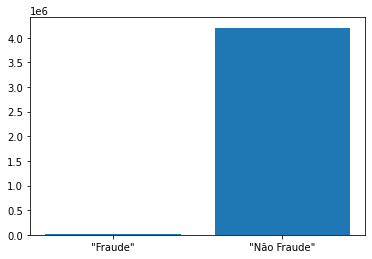

Fraudes: 8213
Não Fraudes: 4202912


In [ ]:
# Fraude vs Não Fraude sem os Merchants
h = [sum(no_M_df['isFraud']==1), sum(no_M_df['isFraud']==0)]
b = ('"Fraude"', '"Não Fraude"')
y_pos = np.arange(len(b))
plt.figure(figsize=(6, 4))
plt.bar(y_pos, h)
plt.xticks(y_pos, b)
plt.show()

print("Fraudes:",sum(no_M_df['isFraud']==1))
print("Não Fraudes:",sum(no_M_df['isFraud']==0))  

## **3.2 Análise da distribuição dos tipos de transação**

In [ ]:
tipos = data["type"].value_counts()
transactions = tipos.index
quantity = tipos.values

import plotly.express as px
figure = px.pie(data, 
             values=quantity, 
             names=transactions,hole = 0.5, 
             title="Distribuição dos tipos de transação")
figure.show()

In [ ]:
tipos = data_fraude["type"].value_counts()
transactions = tipos.index
quantity = tipos.values

import plotly.express as px
figure = px.pie(data_fraude, 
             values=quantity, 
             names=transactions,hole = 0.5, 
             title="Distribuição dos tipos de transação nos casos de fraude")
figure.show()


Notamos que todas as fraudes são transações dos tipos CASH_OUT ou TRANSFER.

## **3.3 Correlação entre cada variável e a coluna "isFraud"**

In [ ]:
# Checando a correlação

# Obtém a matriz de correlação dos dados
correlacao = data.corr()
# Impressão da correlação de cada variável à váriavel "isFraud"
print(correlacao["isFraud"].sort_values(ascending=False))

isFraud           1.000000
amount            0.076688
isFlaggedFraud    0.044109
step              0.031578
type              0.016171
oldbalanceOrg     0.010154
newbalanceDest    0.000535
oldbalanceDest   -0.005885
newbalanceOrig   -0.008148
Name: isFraud, dtype: float64


Notamos que a variável mais correlacionada com a fraude é a quantidade de dinheiro transferida.

## **3.4.1. Boxplot das variáveis com os merchants**

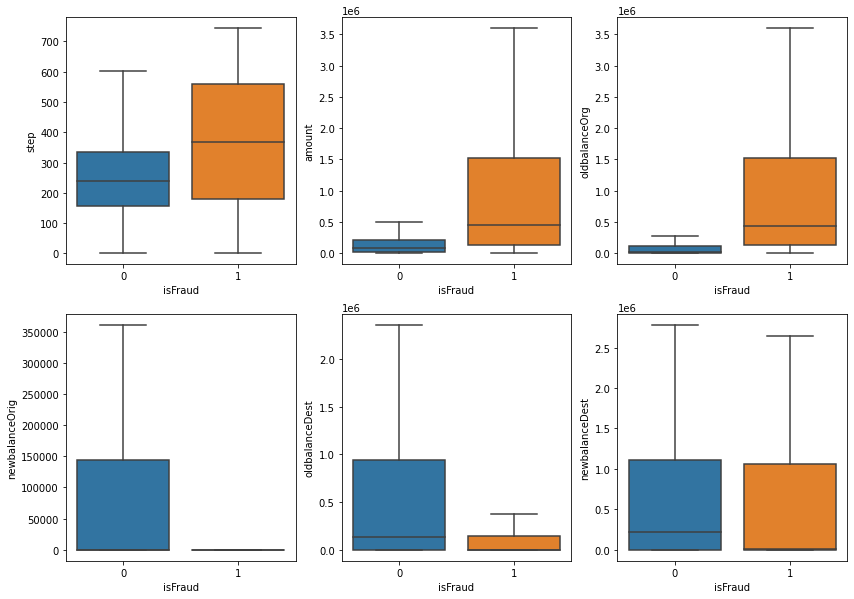

In [ ]:
variables = ['step', 'amount', 'oldbalanceOrg',
       'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

plt.figure(figsize=(14,10))
for i in range(len(variables)):
    plt.subplot(2,3,i+1)
    sns.boxplot(x="isFraud", y=variables[i], data=data, showfliers = False)
    # note que os outliers não estão sendo mostrados

Note que a quantidade de zeros em contas do tipo "Merchant" distorce o boxplot

## **3.4.2. Boxplot das variáveis sem os merchants**

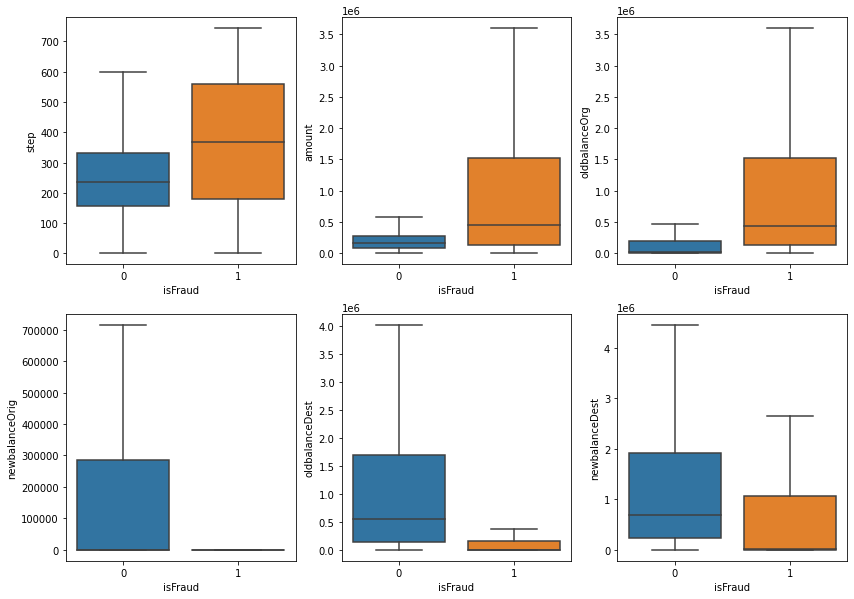

In [ ]:
variables = ['step', 'amount', 'oldbalanceOrg',
       'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

plt.figure(figsize=(14,10))
for i in range(len(variables)):
    plt.subplot(2,3,i+1)
    sns.boxplot(x="isFraud", y=variables[i], data=no_M_df, showfliers = False)
    # note que os outliers não estão sendo mostrados

## **3.4 Heatmap com a correlação entre as variáveis**

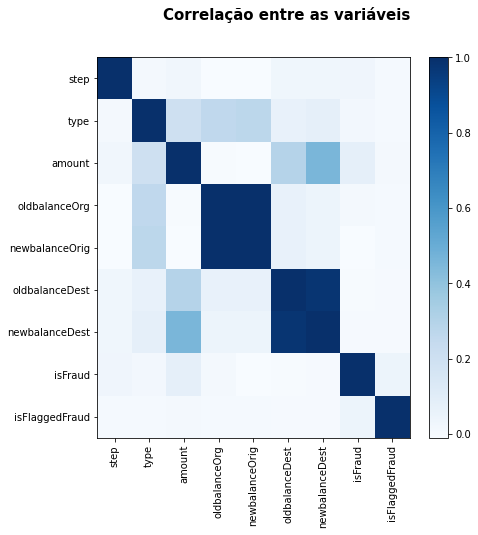

In [ ]:
# A matriz de correlação entre as variáveis:

plt.figure(figsize=(7, 7))
plt.imshow(correlacao, cmap='Blues', interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(correlacao)), correlacao.columns, rotation='vertical')
plt.yticks(range(len(correlacao)), correlacao.columns);
plt.suptitle("Correlação entre as variáveis", fontsize=15, fontweight='bold')
plt.grid(False)
plt.show()

In [ ]:
# Assim, para identificarmos as variáveis correlacionadas, usamos um laço for:

p = 0.75 # correlação mínima
var = []
for i in correlacao.columns:
    for j in correlacao.columns:
        if(i != j):
            if np.abs(correlacao[i][j]) > p: # se maior do que |p|
                var.append([i,j])
print('Variáveis mais correlacionadas:\n', var)

Variáveis mais correlacionadas:
 [['oldbalanceOrg', 'newbalanceOrig'], ['newbalanceOrig', 'oldbalanceOrg'], ['oldbalanceDest', 'newbalanceDest'], ['newbalanceDest', 'oldbalanceDest']]


## **3.5 Análise Exploratória (sem os Merchants)**

In [ ]:
data = pd.read_csv("/content/PS_20174392719_1491204439457_log.csv")

In [ ]:
print('Dados que não têm nenhum valor NULL:')
data.isnull().any()

Dados que não têm nenhum valor NULL:


step              False
type              False
amount            False
nameOrig          False
oldbalanceOrg     False
newbalanceOrig    False
nameDest          False
oldbalanceDest    False
newbalanceDest    False
isFraud           False
isFlaggedFraud    False
dtype: bool

In [ ]:
data.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
data.rename(columns={'newbalanceOrig':'newbalanceOrg'},inplace=True)
# A coluna newbalanceOrig deveria ser newbalanceOrg, como a sua 'espelhada' oldbalanceOrg
data.drop(labels=['nameOrig','nameDest'],axis=1,inplace=True)

In [ ]:
print('Minimum value of Amount, Old/New Balance of Origin/Destination:')
data[[ 'amount','oldbalanceOrg', 'newbalanceOrg', 'oldbalanceDest', 'newbalanceDest']].min()

Minimum value of Amount, Old/New Balance of Origin/Destination:


amount            0.0
oldbalanceOrg     0.0
newbalanceOrg     0.0
oldbalanceDest    0.0
newbalanceDest    0.0
dtype: float64

In [ ]:
print('Maximum value of Amount, Old/New Balance of Origin/Destination:')
data[[ 'amount','oldbalanceOrg', 'newbalanceOrg', 'oldbalanceDest', 'newbalanceDest']].max()

Maximum value of Amount, Old/New Balance of Origin/Destination:


amount            9.244552e+07
oldbalanceOrg     5.958504e+07
newbalanceOrg     4.958504e+07
oldbalanceDest    3.560159e+08
newbalanceDest    3.561793e+08
dtype: float64

Como não há valor ausente e/ou valores 'estranhos', não há necessidade de limpeza de dados, mas ainda precisamos realizar a análise de dados, pois os dados contêm uma grande variação do valor em diferentes colunas. A normalização também melhorará a precisão geral do modelo de aprendizado de máquina.

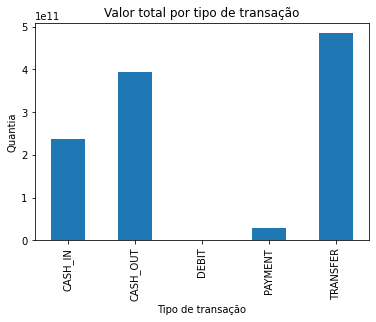

In [ ]:
var = data.groupby('type').amount.sum()
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
var.plot(kind='bar')
ax1.set_title("Valor total por tipo de transação")
ax1.set_xlabel('Tipo de transação')
ax1.set_ylabel('Quantia');

In [ ]:
data.loc[data.isFraud == 1].type.unique()

array(['TRANSFER', 'CASH_OUT'], dtype=object)


O gráfico acima mostra que TRANSFER e CASH_OUT são os dois modos de transação mais usados ​​e podemos ver que TRANSFER e CASH_OUT também são a única maneira pela qual a fraude acontece. Assim, vamos nos concentrar neste tipo de transações.

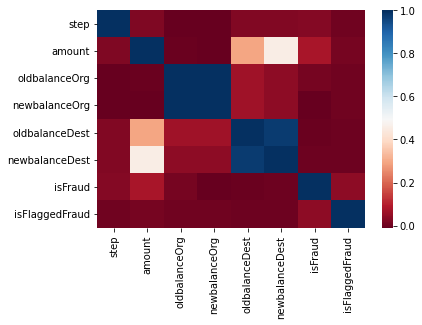

In [ ]:
sns.heatmap(data.corr(),cmap='RdBu');

Coisas que podemos concluir deste mapa de calor:

- OldbalanceOrg e NewbalanceOrg são altamente correlacionados.
- OldbalanceDest e NewbalanceDest são altamente correlacionados.
- O valor está correlacionado com isFraud (variável escolhida).

Não existe muita relação entre as características, então precisamos entender onde a relação entre elas depende do tipo de transação e valor. Para fazer isso, precisamos ver o mapa de calor das transações fraudulentas e não fraudulentas de maneira diferente.

In [ ]:
fraud = data.loc[data.isFraud == 1]
nonfraud = data.loc[data.isFraud == 0]

In [ ]:
fraudcount = fraud.isFraud.count()
nonfraudcount = nonfraud.isFraud.count()

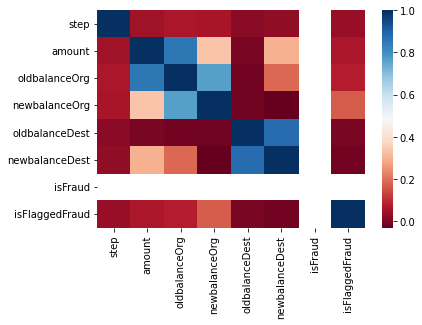

In [ ]:
sns.heatmap(fraud.corr(),cmap='RdBu',);

Existem 2 sinalizadores que se destacam, é interessante observar: coluna isFraud e isFlaggedFraud. A partir da hipótese, isFraud é o indicador que indica as transações fraudulentas reais, enquanto isFlaggedFraud é o que o sistema impede a transação devido ao acionamento de alguns limites. No mapa de calor acima, podemos ver que há alguma relação entre outras colunas e isFlaggedFraud, portanto, deve haver relação entre isFraud.

In [ ]:
print(f'O número total de transações fraudulentas é {data.isFraud.sum()}.')
print(f'O número total de transações fraudulentas marcadas como fraude é {data.isFlaggedFraud.sum()}.')
print(f'A proporção de transação fraudulenta versus transação não fraudulenta é 1: {int(nonfraudcount//fraudcount)}.')

O número total de transações fraudulentas é 8213.
O número total de transações fraudulentas marcadas como fraude é 16.
A proporção de transação fraudulenta versus transação não fraudulenta é 1: 773.


In [ ]:
print('A cada 773 transações, 1 é fraudulenta.')
print(f'O valor perdido devido a essas transações fraudulentas é de $ {int(fraud.amount.sum())}.')

A cada 773 transções, 1 é fraudulenta.
O valor perdido devido a essas transações fraudulentas é de $ 12056415427.


In [ ]:
piedata = fraud.groupby(['isFlaggedFraud']).sum()

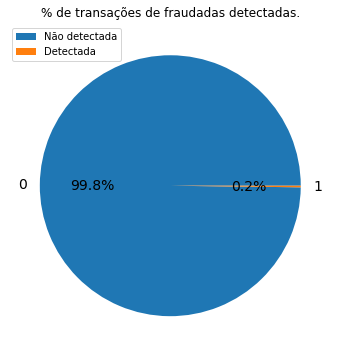

In [ ]:
f, axes = plt.subplots(1,1, figsize=(6,6))
axes.set_title("% de transações fraudadas detectadas.")
piedata.plot(kind='pie',y='isFraud',ax=axes, fontsize=14,shadow=False,autopct='%1.1f%%');
axes.set_ylabel('');
plt.legend(loc='upper left',labels=['Não detectada','Detectada'])
plt.show()

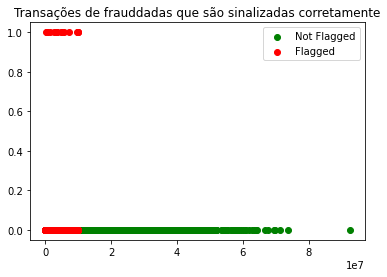

In [ ]:
fig = plt.figure()
axes = fig.add_subplot(1,1,1)
axes.set_title("Transações fraudadas que são sinalizadas corretamente")
axes.scatter(nonfraud['amount'],nonfraud['isFlaggedFraud'],c='g')
axes.scatter(fraud['amount'],fraud['isFlaggedFraud'],c='r')
plt.legend(loc='upper right',labels=['Not Flagged','Flagged'])
plt.show()

O gráfico acima mostra claramente a necessidade de um sistema que seja rápido e confiável para marcar a transação que é fraude. Desde então, o sistema atual permite que transações fraudulentas passem por um sistema que não as rotula como fraudulentas. Alguma exploração de dados pode ser útil para verificar a relação entre os recursos.

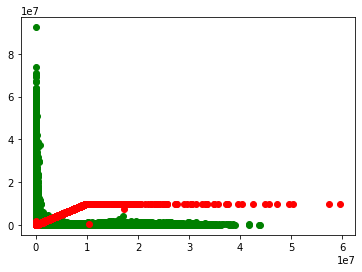

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(nonfraud['oldbalanceOrg'],nonfraud['amount'],c='g')
ax.scatter(fraud['oldbalanceOrg'],fraud['amount'],c='r')
plt.show()

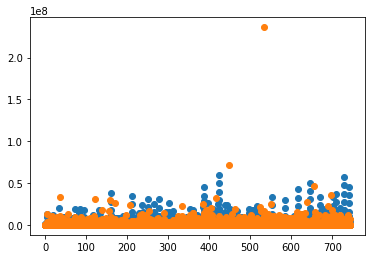

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(fraud['step'],fraud['oldbalanceOrg'])
ax.scatter(fraud['step'],fraud['oldbalanceDest'])
plt.show()

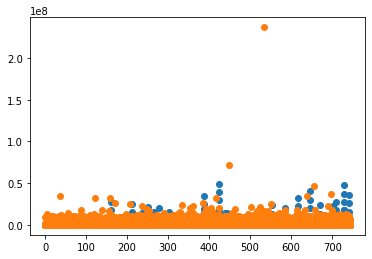

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(fraud['step'],fraud['newbalanceOrg'])
ax.scatter(fraud['step'],fraud['newbalanceDest'])
plt.show()

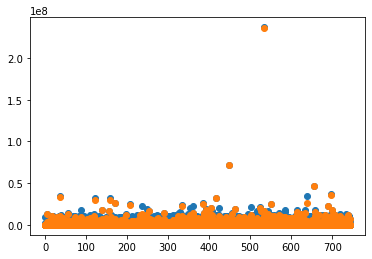

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(fraud['step'],fraud['newbalanceDest'])
ax.scatter(fraud['step'],fraud['oldbalanceDest'])
plt.show()

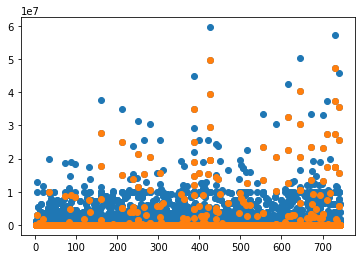

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(fraud['step'],fraud['oldbalanceOrg'])
ax.scatter(fraud['step'],fraud['newbalanceOrg'])
plt.show()

## **4. Classificadores**

A partir da exploração dos dados, definimos modelos que levam em conta o tipo de transação, a quantidade transferida e o saldo da conta de origem antes e depois da transação.

### Preparamos o conjunto de treinamento e teste com estratificação da variável "isFraud" para o conjunto de dados com os Merchants:

In [ ]:
X_cm = np.array(data[["type", "amount", "oldbalanceOrg", "newbalanceOrig"]])
y_cm = np.array(data[["isFraud"]])
y_cm = np.ravel(y_cm)
classes = np.unique(y_cm) 

# Seleciona os conjuntos de treinamento e teste
p = 0.7 
X_cm_train, X_cm_test, y_cm_train, y_cm_test = train_test_split(X_cm, y_cm, stratify=y_cm,
                                                    train_size = p, random_state = 42)

# Normalização
scaler = StandardScaler().fit(X_cm_train)
X_cm_train = scaler.transform(X_cm_train)
X_cm_test = scaler.transform(X_cm_test)

### Preparando o conjunto de treinamento e teste com estratificação da variável "isFraud" para o conjunto de dados sem os Merchants:

In [ ]:
X_sm = np.array(no_M_df[["type", "amount", "oldbalanceOrg", "newbalanceOrig"]])
y_sm = np.array(no_M_df[["isFraud"]])
y_sm = np.ravel(y_sm)
classes = np.unique(y_sm)

# Seleciona os conjuntos de treinamento e teste
p = 0.7 
X_sm_train, X_sm_test, y_sm_train, y_sm_test = train_test_split(X_sm, y_sm, stratify=y_sm,
                                                    train_size = p, random_state = 42)

# Normalização
scaler = StandardScaler().fit(X_sm_train)
X_sm_train = scaler.transform(X_sm_train)
X_sm_test = scaler.transform(X_sm_test)

## **4.1. Classificador Naive Bayes** 

### **4.1.1. Classificador Naive Bayes para os dados com os Merchants**

In [ ]:
# Ajuste do modelo
model = GaussianNB()
model.fit(X_cm_train, y_cm_train)
y_pred_cm = model.predict(X_cm_test)

- Matriz de confusão

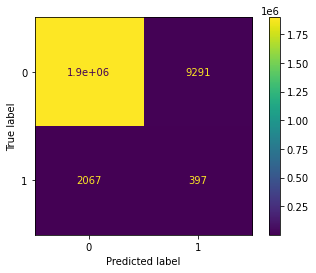

In [ ]:
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_cm_test, y_pred_cm)).plot()
plt.show()

- Classification report

In [ ]:
print(classification_report(y_cm_test, y_pred_cm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.04      0.16      0.07      2464

    accuracy                           0.99   1908786
   macro avg       0.52      0.58      0.53   1908786
weighted avg       1.00      0.99      1.00   1908786



### **4.1.2. Classificador Naive Bayes para os dados sem os Merchants**

In [ ]:
# Ajuste do modelo
model = GaussianNB()
model.fit(X_sm_train, y_sm_train)
y_pred_sm = model.predict(X_sm_test)

- Matriz de confusão

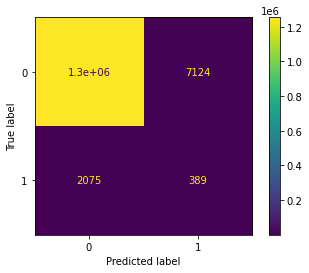

In [ ]:
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_sm_test, y_pred_sm)).plot()
plt.show()

- Classification report

In [ ]:
print(classification_report(y_sm_test, y_pred_sm))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1260874
           1       0.05      0.16      0.08      2464

    accuracy                           0.99   1263338
   macro avg       0.53      0.58      0.54   1263338
weighted avg       1.00      0.99      0.99   1263338



## **4.2. Regressão Logística**

### **4.2.1. Regressão Logística para os dados com os Merchants**

In [ ]:
# Ajuste do modelo
model = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter = 1000)
model.fit(X_cm_train, y_cm_train)
y_pred_cm = model.predict(X_cm_test)

- Matriz de confusão

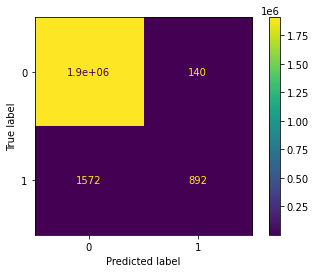

In [ ]:
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_cm_test, y_pred_cm)).plot()
plt.show()

- Classification report

In [ ]:
print(classification_report(y_cm_test, y_pred_cm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.86      0.36      0.51      2464

    accuracy                           1.00   1908786
   macro avg       0.93      0.68      0.75   1908786
weighted avg       1.00      1.00      1.00   1908786



### **4.2.2. Regressão Logística para os dados sem os Merchants**

In [ ]:
# Ajuste do modelo
model = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter = 1000)
model.fit(X_sm_train, y_sm_train)
y_pred_sm = model.predict(X_sm_test)

- Matriz de confusão

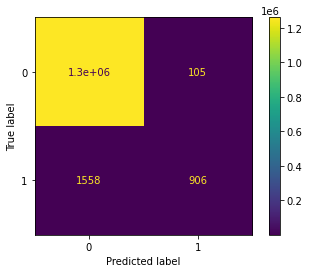

In [ ]:
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_sm_test, y_pred_sm)).plot()
plt.show()

- Classification report

In [ ]:
print(classification_report(y_sm_test, y_pred_sm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1260874
           1       0.90      0.37      0.52      2464

    accuracy                           1.00   1263338
   macro avg       0.95      0.68      0.76   1263338
weighted avg       1.00      1.00      1.00   1263338



## **4.3. Árvore de Decisão**

### **4.3.1. Árvore de Decisão para os dados com os Merchants**

In [ ]:
# Ajuste do modelo
model = DecisionTreeClassifier()
model.fit(X_cm_train, y_cm_train)
y_pred_cm = model.predict(X_cm_test)

- Matriz de confusão

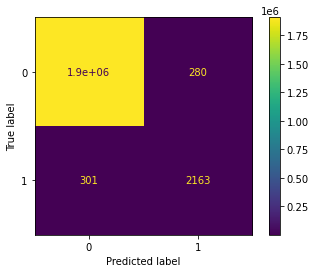

In [ ]:
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_cm_test, y_pred_cm)).plot()
plt.show()

- Classification report

In [ ]:
print(classification_report(y_cm_test, y_pred_cm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.89      0.88      0.88      2464

    accuracy                           1.00   1908786
   macro avg       0.94      0.94      0.94   1908786
weighted avg       1.00      1.00      1.00   1908786



### **4.3.2. Árvore de Decisão para os dados sem os Merchants**

In [ ]:
# Ajuste do modelo
model = DecisionTreeClassifier()
model.fit(X_sm_train, y_sm_train)
y_pred_sm = model.predict(X_sm_test)

- Matriz de confusão

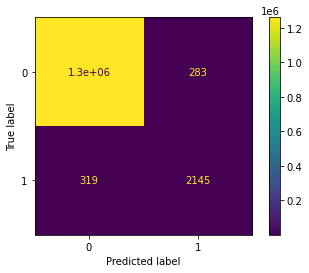

In [ ]:
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_sm_test, y_pred_sm)).plot()
plt.show()

- Classification report

In [ ]:
print(classification_report(y_sm_test, y_pred_sm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1260874
           1       0.88      0.87      0.88      2464

    accuracy                           1.00   1263338
   macro avg       0.94      0.94      0.94   1263338
weighted avg       1.00      1.00      1.00   1263338



## **4.4. K-Vizinhos**

### **4.4.1 K-Vizinhos para os dados com os Merchants**

In [ ]:
k = 1 # numero de vizinhos
# Ajuste do modelo
model = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
model.fit(X_cm_train,y_cm_train)
y_pred_cm = model.predict(X_cm_test) 

- Matriz de confusão

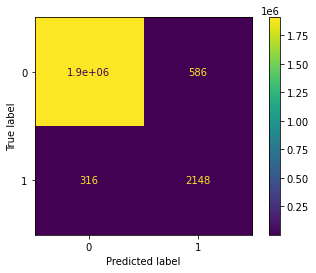

In [ ]:
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_cm_test, y_pred_cm)).plot()
plt.show()

- Classification report

In [ ]:
print(classification_report(y_cm_test, y_pred_cm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.79      0.87      0.83      2464

    accuracy                           1.00   1908786
   macro avg       0.89      0.94      0.91   1908786
weighted avg       1.00      1.00      1.00   1908786



### **4.4.2. K-Vizinhos para os dados sem os Merchants**

In [ ]:
k = 1 # numero de vizinhos
# Ajuste do modelo
model = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
model.fit(X_sm_train,y_sm_train)
y_pred_sm = model.predict(X_sm_test) 

- Matriz de confusão

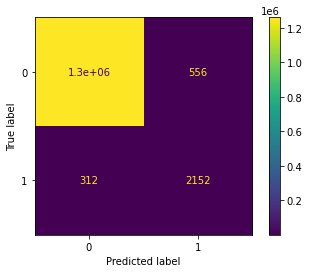

In [ ]:
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_sm_test, y_pred_sm)).plot()
plt.show()

- Classification report

In [ ]:
print(classification_report(y_sm_test, y_pred_sm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1260874
           1       0.79      0.87      0.83      2464

    accuracy                           1.00   1263338
   macro avg       0.90      0.94      0.92   1263338
weighted avg       1.00      1.00      1.00   1263338



## **4.5. Random Forest**

### **4.5.1. Random Forest para os dados com os Merchants**

Number of Estimators: 1 Accuracy: 0.9995934588790991
Number of Estimators: 11 Accuracy: 0.9997223366055702
Number of Estimators: 21 Accuracy: 0.9997380534014814
Number of Estimators: 31 Accuracy: 0.9997495790518162
Number of Estimators: 41 Accuracy: 0.9997359578286932
Number of Estimators: 51 Accuracy: 0.9997427684402547
Number of Estimators: 61 Accuracy: 0.9997422445470576
Number of Estimators: 71 Accuracy: 0.9997401489742695
Number of Estimators: 81 Accuracy: 0.9997417206538606
Number of Estimators: 91 Accuracy: 0.9997432923334517
Melhor n: 31  com acurácia: 0.9997495790518162


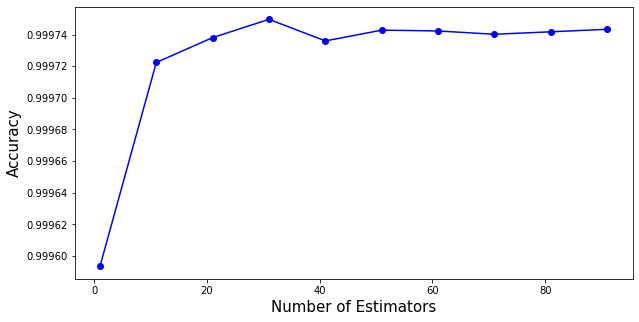

In [ ]:
# Ajuste do modelo
vscore = []
vn = []
for n in range(1,100,10):
    model = RandomForestClassifier(n_estimators=n)
    model.fit(X_cm_train,y_cm_train)
    y_pred_cm = model.predict(X_cm_test) 
    score = accuracy_score(y_pred_cm, y_cm_test)
    print('Number of Estimators:', n, 'Accuracy:', score)
    vscore.append(score)
    vn.append(n)
best_n = vn[np.argmax(vscore)]
print('Melhor n:', best_n, ' com acurácia:', vscore[np.argmax(vscore)] )
plt.figure(figsize=(10,5))
plt.plot(vn, vscore, '-bo')
plt.xlabel('Number of Estimators', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.show()

In [ ]:
# Define os parâmetros do modelo
model=RandomForestClassifier(n_estimators=31)
model.fit(X_cm_train,y_cm_train)
y_pred_cm = model.predict(X_cm_test)

- A curva ROC indica um bom ajuste do modelo para a classificação

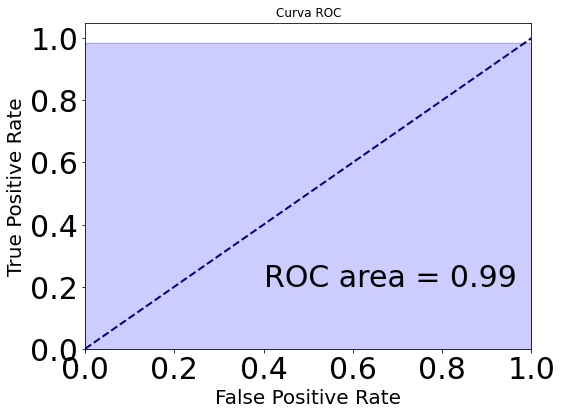

In [ ]:
y_predict_probabilities = model.predict_proba(X_cm_test)[:,1]
test_y = np.array(y_cm_test, dtype = 'int')
fpr, tpr, thresholds = roc_curve(y_cm_test, y_predict_probabilities)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.step(fpr, tpr, color='b', alpha=0.1, where='post')
plt.fill_between(fpr, tpr, step='post', alpha=0.2, color='b')
plt.text(0.4, 0.2, 'ROC area = %0.2f' % roc_auc, fontsize = 30)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.xticks(color='k', size=30)
plt.yticks(color='k', size=30)
plt.title('Curva ROC')
plt.show()

- Matriz de confusão

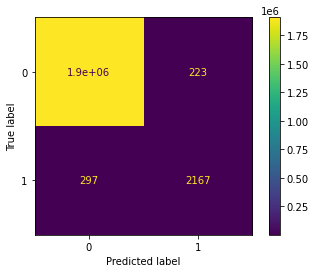

In [ ]:
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_cm_test, y_pred_cm)).plot()
plt.show()

- Classification report

In [ ]:
print(classification_report(y_cm_test, y_pred_cm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.91      0.88      0.89      2464

    accuracy                           1.00   1908786
   macro avg       0.95      0.94      0.95   1908786
weighted avg       1.00      1.00      1.00   1908786



### **4.5.2. Random Forest para os dados sem os Merchants**

Number of Estimators: 1 Accuracy: 0.9993343032505948
Number of Estimators: 11 Accuracy: 0.9995591045310123
Number of Estimators: 21 Accuracy: 0.9995670200690552
Number of Estimators: 31 Accuracy: 0.9995567298695994
Number of Estimators: 41 Accuracy: 0.9995852258065537
Number of Estimators: 51 Accuracy: 0.9995670200690552
Number of Estimators: 61 Accuracy: 0.9995828511451409
Number of Estimators: 71 Accuracy: 0.9995796849299238
Number of Estimators: 81 Accuracy: 0.9995788933761195
Number of Estimators: 91 Accuracy: 0.9995733524994894
Melhor n: 41  com acurácia: 0.9995852258065537


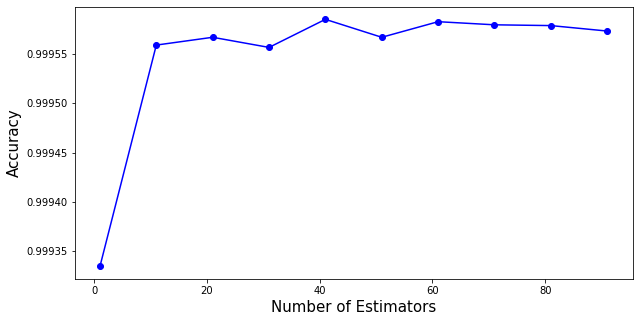

In [ ]:
# Ajuste do modelo
vscore = []
vn = []
for n in range(1,100,10):
    model = RandomForestClassifier(n_estimators=n)
    model.fit(X_sm_train,y_sm_train)
    y_pred_sm = model.predict(X_sm_test) 
    score = accuracy_score(y_pred_sm, y_sm_test)
    print('Number of Estimators:', n, 'Accuracy:', score)
    vscore.append(score)
    vn.append(n)
best_n = vn[np.argmax(vscore)]
print('Melhor n:', best_n, ' com acurácia:', vscore[np.argmax(vscore)] )
plt.figure(figsize=(10,5))
plt.plot(vn, vscore, '-bo')
plt.xlabel('Number of Estimators', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.show()

In [ ]:
# Define os parâmetros do modelo
model=RandomForestClassifier(n_estimators=41)
model.fit(X_sm_train,y_sm_train)
y_pred_sm = model.predict(X_sm_test)

- A curva ROC indica um bom ajuste do modelo para a classificação

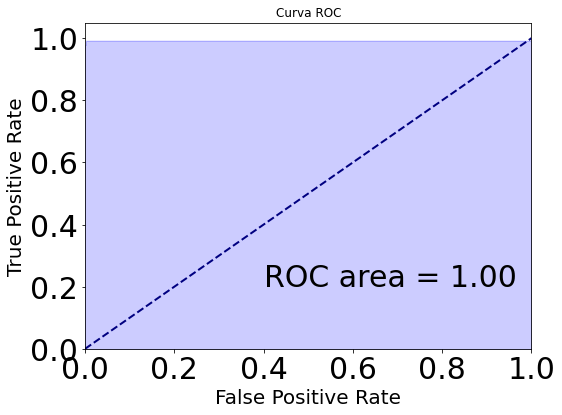

In [ ]:
y_predict_probabilities = model.predict_proba(X_sm_test)[:,1]
test_y = np.array(y_sm_test, dtype = 'int')
fpr, tpr, thresholds = roc_curve(y_sm_test, y_predict_probabilities)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.step(fpr, tpr, color='b', alpha=0.1, where='post')
plt.fill_between(fpr, tpr, step='post', alpha=0.2, color='b')
plt.text(0.4, 0.2, 'ROC area = %0.2f' % roc_auc, fontsize = 30)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.xticks(color='k', size=30)
plt.yticks(color='k', size=30)
plt.title('Curva ROC')
plt.show()

- Matriz de confusão

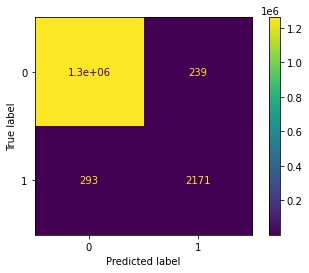

In [ ]:
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_sm_test, y_pred_sm)).plot()
plt.show()

- Classification report

In [ ]:
print(classification_report(y_sm_test, y_pred_sm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1260874
           1       0.90      0.88      0.89      2464

    accuracy                           1.00   1263338
   macro avg       0.95      0.94      0.95   1263338
weighted avg       1.00      1.00      1.00   1263338



## **4.6. Gradient Boosting**

### **4.6.1. Gradient Boosting para os dados com os Merchants**

In [ ]:
# Ajuste do modelo
model = HistGradientBoostingClassifier(random_state=0, learning_rate = 0.1)
model.fit(X_cm_train,y_cm_train)
y_pred_cm = model.predict(X_cm_test) 

- Matriz de confusão

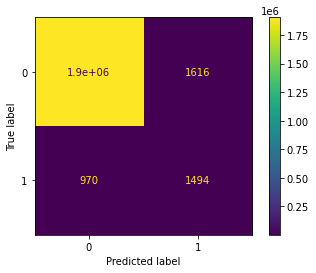

In [ ]:
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_cm_test, y_pred_cm)).plot()
plt.show()

- Classification report

In [ ]:
print(classification_report(y_cm_test, y_pred_cm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.48      0.61      0.54      2464

    accuracy                           1.00   1908786
   macro avg       0.74      0.80      0.77   1908786
weighted avg       1.00      1.00      1.00   1908786



### **4.6.2. Gradient Boosting para os dados sem os Merchants**

In [ ]:
# Ajuste do modelo
model = HistGradientBoostingClassifier(random_state=0, learning_rate = 0.1)
model.fit(X_sm_train,y_sm_train)
y_pred_sm = model.predict(X_sm_test) 

- Matriz de confusão

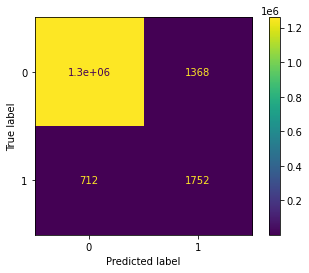

In [ ]:
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_sm_test, y_pred_sm)).plot()
plt.show()

- Classification report

In [ ]:
print(classification_report(y_sm_test, y_pred_sm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1260874
           1       0.56      0.71      0.63      2464

    accuracy                           1.00   1263338
   macro avg       0.78      0.85      0.81   1263338
weighted avg       1.00      1.00      1.00   1263338



## **5. Resultados**

Dos classificadores analisados, obtivemos os seguintes resultados para *precision*, *recall* e *f1-score* para o caso de classificar corretamente os dados fraudulentos:


- Dados com os merchants:

                             precision    recall  f1-score
        Naive Bayes 	     0.04      0.16      0.07
        Regressão Logística  0.86      0.36      0.51
        Árvore de Decisão    0.89      0.88      0.88
        K-Vizinhos           0.79      0.87      0.83
        Random Forest 	   0.91      0.88      0.89
        Gradient Boosting    0.48      0.61      0.54
    
    
    
- Dados sem os merchants:

                             precision    recall  f1-score
        Naive Bayes 	     0.05      0.16      0.08
        Regressão Logística  0.90      0.37      0.52
        Árvore de Decisão    0.88      0.87      0.88
        K-Vizinhos           0.79      0.87      0.83
        Random Forest 	   0.90      0.88      0.89
        Gradient Boosting    0.56      0.71      0.63
    
    
Para o caso de classificar transações não fraudulentas, todos os classificadores apresentaram bons resultados devido a grande disponibilidade de dados neste formato.

A partir das tabelas acima fica claro que o algoritmo *Random Forest* foi o que performou melhor dentre os classificadores analisados.

Vemos ainda uma ligeira melhora nas análises feitas para os dados sem os merchants, o que indica que o volume destes dados que não contém informação relevante para o problema em questão não são significativos e podem ser desconsiderados para no treinamento do modelo.